In [ ]:
from matplotlib import pyplot as plt
import numpy as np
import struct
import scipy.constants as consts
import sys
import os

In [ ]:
plt.rcParams['figure.figsize'] = [12, 10]

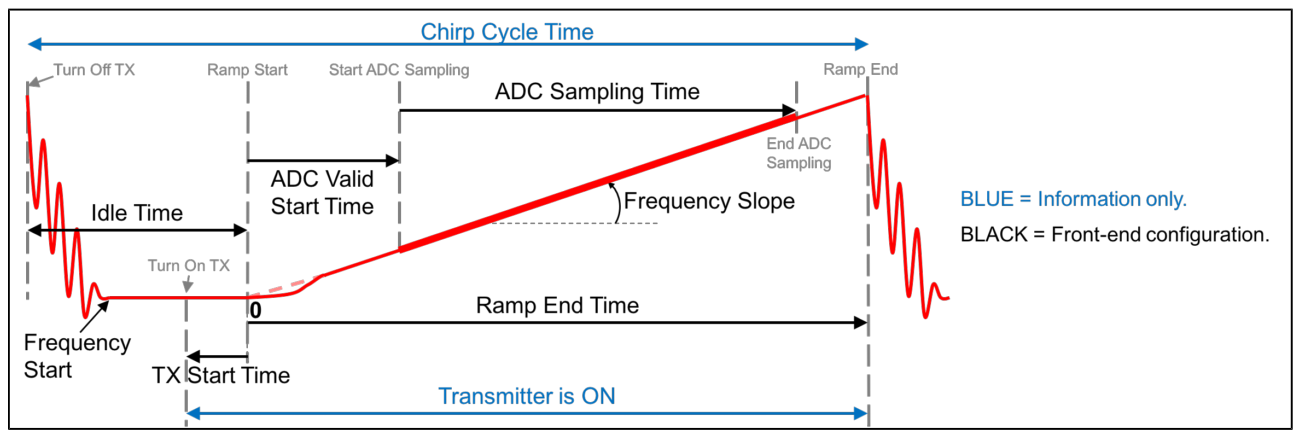

Config CLI
```
flushCfg
dfeDataOutputMode 1
channelCfg 15 1 0
adcCfg 2 1
lowPower 0 1
profileCfg 0 77 20 5 80 0 0  40 1 256 6000 0 0 30
chirpCfg 0 0 0 0 0 0 0 1
frameCfg 0 0 128 1024 20 1 0
testFmkCfg 0 0 0 1
setProfileCfg disable ADC disable
sensorStart

sensorStop
```

In [ ]:
radarCfg = {'start_frequency': 76e9,
            'idle': 100e-6,
            'adcStartTime': 6e-6,
            'rampEndTime': 60e-6,
            'txStartTime': 1e-6,
            'adcSamples': 128,
            'adcSampleRate': 3000e3,
            'freqSlopeConst': 40e6/1e-6,
            'txPower': 0,
            'txPhaseShift': 0,
            'hpfCornerFreq1': 0,
            'hpfCornerFreq2': 0,
            'rxGain': 30,
            'numChirps': 128,
            'numLanes': 4,
            'isComplex': True,
           }

In [ ]:
def make_profile_string(cfg):
    """IWR14xx CLI string:
    profileCfg <profileId> <startFreq> <idleTime> <adcStartTime> <rampEndTime> <txOutPower> <txPhaseShifter> <freqSlopeConst> <txStartTime> <numAdcSamples> <digOutSampleRate> <hpfCornerFreq1> <hpfCornerFreq2> <rxGain>
    
    profileId        - int
    startFreq        - float, GHz
    idleTime         - float, us
    adcStartTime     - float, us
    rampEndtime      - float, us
    txOutPower       - float, dB
    txPhaseShifter   - float
    freqSlopeConst   - float, Mhz/us
    txStartTime      - float, us
    numADCSamples    - int
    digOutSampleRate - int, kHz
    hpfCornerFreq1   - 0
    hpfCornerFreq2   - 0
    rxGain           - float, dB
    """
    profileStr = 'profileCfg {} {:.3f} {:.3f} {:.3f} {:.3f} {} {} {:.3f} {} {:.0f} {:.0f} {} {} {:.0f}'.format(
        0,
        cfg['start_frequency']/1e9,
        cfg['idle']/1e-6, 
        cfg['adcStartTime']/1e-6,
        cfg['rampEndTime']/1e-6,
        cfg['txPower'],
        cfg['txPhaseShift'],
        cfg['freqSlopeConst']/1e6*1e-6,
        cfg['txStartTime']/1e-6,
        cfg['adcSamples'],
        cfg['adcSampleRate']/1e3,
        cfg['hpfCornerFreq1'],
        cfg['hpfCornerFreq2'],
        cfg['rxGain']
    )
    return profileStr

def cmd_to_dict(cmd_str, curr_cfg = None):
    #TODO: implement others according to documentation
    cmd_split = cmd_str.split()
    
    if cmd_split[0] == 'profileCfg':
        curr_cfg = profileStr_to_dict(cmd_split[1:], curr_cfg)
    else:
        raise ValueError(f"Unknown command {cmd_split[0]}")
        
    return curr_cfg

def dict_to_cli(config):
    #TODO: implement
    pass
    
def profileStr_to_dict(args, curr_cfg = None):
    normalizer = [None, 1e9, 1e-6, 1e-6, 1e-6, None, None, 1, 1e-6, None, 1e3, None, None, None]
    dtype = [int, float, float, float, float, float, float, float, float, int, float, int, int, float]
    keys = ['id',
            'start_frequency',
            'idle',
            'adcStartTime',
            'rampEndTime',
            'txPower',
            'txPhaseShift',
            'freqSlopeConst',
            'txStartTime',
            'adcSamples',
            'adcSampleRate',
            'hpfCornerFreq1',
            'hpfCornerFreq2',
            'rxGain',
           ]
    if curr_cfg:
        cfg = curr_cfg
    else:
        cfg = {}
            
    for k, v, n, d in zip(keys, args, normalizer, dtype):
        cfg[k] = d(float(v) * n if n else v)
    return cfg

In [ ]:
make_profile_string(radarCfg)

In [ ]:
_test = {}
_test['numChirps'] = 128
cmd_to_dict("profileCfg 0 77.000 10.000 5.000 80.000 0 0 40.000 1.0 256 6000 0 0 30", _test)

## Helper functions to get physical units

Everything is in SI units (metric)

In [ ]:
def compute_interchirp_time(cfg):
    return cfg['idle']+cfg['rampEndTime']

def fft_bin2freq(fft_bin, cfg, fft_shift=False):
    #TODO: handle fftshift?
    return np.fft.fftfreq(cfg['adcSamples'], 1/cfg['adcSampleRate'])[fft_bin]

def freq2range(beat_freq, cfg):
    return beat_freq * consts.c/(2*cfg['freqSlopeConst'])

def fft_bin2range(fft_bin, cfg):
    return freq2range(fft_bin2freq(fft_bin, cfg), cfg)

def doppler_bin2velocity(doppler_bin, cfg, shifted=True):
    tc = compute_interchirp_time(cfg)
    lambd = consts.c/cfg['start_frequency']
    dv = lambd/(2*cfg['numChirps']*tc)
    v = np.arange(cfg['numChirps'])*dv
    if shifted:
        zero_idx = np.argmin(np.fft.fftshift(np.arange(cfg['numChirps'])))
        v -= v[zero_idx]
    return v[doppler_bin]

## IO Helper functions

`zeropad_missing_packets` limitations:
 - Currently only handles ADC mode correctly (i.e. no headers)
 - cannot handle out of order packets: (TODO: implement either reorder or discard)
 - Needs to know now to hand CP_ADC_CQ, CP_ADC modes. 

In [ ]:
def read_raw_udp(filename, PACKET_LENGTH = 1466):
    with open(filename, 'rb') as raw_capture:
        packet_data = []
        for chunk in iter(lambda: raw_capture.read(PACKET_LENGTH), ''):
            if len(chunk) < PACKET_LENGTH:
                print('Remainder bytes: {}. Something is wrong if not 0'.format(len(chunk)))
                break
            else:
                packet_data.append(chunk)
        print('{} packets read.'.format(len(packet_data)))
    
    return packet_data

In [ ]:
def zeropad_missing_packets(packet_data, config, verbose=True):
    #TODO: implement reorder
    seqn_ = 0
    bytec_ = 0
    samples = []

    numBytesPerFrame = 2*config['adcSamples']*config['numLanes']*config['numChirps']
    if config['isComplex']:
        numBytesPerFrame *= 2
    numSamplesPerFrame = numBytesPerFrame/2
    print("Bytes per frame: {}".format(numBytesPerFrame))
    packetsPerFrame = numBytesPerFrame/1456
    print("Packets per frame: {}".format(packetsPerFrame))

    for packet in packet_data:
        seqn, _b, bytec = struct.unpack('<III', packet[:12])
        if seqn_ +1 != seqn:
            packets_lost = seqn - seqn_
            bytes_lost = bytec - bytec_
            if verbose:
                print("@frame {}-{}: lost {} packets ({} bytes, {} samples, {:.3f} frames)".format(seqn_/packetsPerFrame,
                                                                                                   seqn/packetsPerFrame,
                                                                                                   packets_lost,
                                                                                                   bytes_lost,
                                                                                                   (bytes_lost)/2,
                                                                                                   bytes_lost/numBytesPerFrame
                                                                                                  ))

            samples.append(np.zeros((bytec-bytec_)-1466//2, dtype=np.int16))
        samples.append(np.frombuffer(packet[10:], dtype=np.int16))
        seqn_ = seqn
        bytec_ = bytec
    samples = np.concatenate(samples)
    print("Last seqn read {}, last bytecount {} + 1456".format(seqn, bytec))
    print("expected samples length {}".format((bytec + 1456)//2))
    print("Num samples {}".format(samples.shape))

    print("{} frames available:".format(samples.shape[0]/numSamplesPerFrame))
    
    return samples

In [ ]:
def form_data_cube(config, flat_array):
    samples_per_frame = config['adcSamples'] * config['numChirps'] * config['numLanes']
    if config['isComplex']:
        data = flat_array.reshape(-1, 8)
        data = data[:, :4] + 1j* data[:, 4:]
        data.reshape(-1)
    else:
        data = flat_array
        
    samples_to_discard = len(data)%samples_per_frame
    
    if samples_to_discard >0:
        print("Warning: there seems to be incomplete frames. {} samples discarded.".format(samples_to_discard))
        data = data[:-samples_to_discard]
    
    return data.reshape(-1, config['numChirps'], config['adcSamples'], config['numLanes'])


In [ ]:
packet_data = read_raw_udp('C:/Users/RIMMS-RADAR/Desktop/rawdata radar/pp/dataset/hand left right/6.bin', 1470)
samples = zeropad_missing_packets(packet_data, radarCfg)

In [ ]:
for i in range(10):
    print(struct.unpack('<IIIh'+('i'*4), packet_data[i][:14 + 8*2]))

In [ ]:
radar_data_cube = form_data_cube(radarCfg, samples)

## Plotting functions

In [ ]:
def plot_range_time(dataarray, frame_n, rx_n, cfg=None):
    #if cfg is provided, convert to metric units
    rt_fft = np.fft.fft(dataarray[frame_n, :, :, rx_n])
    
    plt.figure()
    range_max = fft_bin2range(rt_fft.shape[1]//2-1, cfg) if cfg else rt_fft.shape[1]
    plt.imshow(np.abs(rt_fft[:, :rt_fft.shape[1]//2]),
               interpolation='nearest',
               extent=(0, range_max, 0, rt_fft.shape[0]),
               aspect=range_max/(5*rt_fft.shape[0]),
               origin='lower'
              )
    plt.title('Chirp(Time)/Range')
    plt.show()
    return rt_fft

def plot_doppler_range(dataarray, frame_n, rx_n, cfg=None):
    rt_fft = np.fft.fft(dataarray[frame_n, :, :, rx_n])
    dr_fft = np.fft.fftshift(np.fft.fft(rt_fft, axis=0), axes=0)
    
    plt.figure()
    range_max = fft_bin2range(rt_fft.shape[1]//2-1, cfg) if cfg else rt_fft.shape[1]
    v_min = doppler_bin2velocity(0, cfg)
    v_max = doppler_bin2velocity(cfg['numChirps']-1, cfg)
    plt.imshow(np.abs(dr_fft[:, :rt_fft.shape[1]//2]),
               interpolation='nearest',
               extent=(0, range_max, v_min, v_max),
               aspect=range_max/(v_max-v_min),
               origin='lower'
              )
    plt.title('Dopper/Range')
    plt.show()
    return dr_fft

def plot_range_azimuth(dataarray, frame_n, chirp_n, cfg=None):
    rt_fft = np.fft.fft(dataarray[frame_n, :, :, :], axis=1)
    dr_fft = np.fft.fftshift(np.fft.fft(rt_fft, axis=0), axes=0)
    azi_fft = np.fft.fftshift(np.fft.fft(dr_fft, axis=2), axes=2)
    
    plt.figure()
    
    range_max = fft_bin2range(rt_fft.shape[1]//2-1, cfg) if cfg else rt_fft.shape[1]
    
    plt.imshow(np.abs(azi_fft[chirp_n, :rt_fft.shape[1]//2, :]),
               interpolation='nearest', 
               extent=(-np.pi/2, np.pi/2, 0, fft_bin2range(127, radarCfg)),
               aspect=np.pi/range_max,
               origin='lower'
              )
    plt.title('Range/Azimuth(rad)')
    return azi_fft

In [ ]:
range_fft = plot_range_time(radar_data_cube, 10, 0, radarCfg)
doppler_fft = plot_doppler_range(radar_data_cube, 10, 0, radarCfg)
azi_fft = plot_range_azimuth(radar_data_cube, 10, 0, radarCfg)

## Verify with binary generated by `Packet_Reorder_Zerofill.exe`

In [ ]:
samples2 = np.fromfile('C:/Users/RIMMS-RADAR/Desktop/rawdata radar/pp/dataset/hand front back/1.bin', dtype='int16',  )

In [ ]:
radarCfg2 =  radarCfg.copy()
radarCfg2['adcSamples'] = 256
radarCfg2['isComplex'] = False
radarCfg2['numLanes'] = 4
radarCfg2

In [ ]:
radar_data2 = form_data_cube(radarCfg2, samples2)
print(radar_data2.shape)

In [ ]:
f0_rx0 = radar_data2[29, :, :, :]
print(f0_rx0.shape)

range_fft = plot_range_time(radar_data2, 29, 0, radarCfg2)
doppler_fft = plot_doppler_range(radar_data2, 29, 0, radarCfg2)
azi_fft = plot_range_azimuth(radar_data2, 29, 0, radarCfg2)

# Dummy data
Check if we are doing the right thing

In [ ]:
#uncorrelated noise
sim_sig = np.random.uniform(high=.01, low=-.01, size=[128, 256])

tt = np.arange(256)*(1/6000e3)
#IF 1 @ 500hz , phase shift 0.01 rad phase per chirp
if1 = np.array([np.sin( 2* np.pi * 500000 * tt + 0.4 * n) for n in range(128)])

#IF 2 @ 500hz , phase shift -0.01 rad phase per chirp
if2 = np.array([np.sin( 2* np.pi * 500000 * tt + 0.9 * n) for n in range(128)])

#IF 3 @ 1500hz , phase shift -0.02 rad phase per chirp
if3 = np.array([np.sin( 2* np.pi * 150000 * tt - 0.2 * n) for n in range(128)])


In [ ]:
plt.imshow(np.abs(np.fft.fftshift(np.fft.fft2(sim_sig+if1+if2+if3))))

In [ ]:
# Copyright 2019 The OpenRadar Authors. All Rights Reserved.
# Licensed under the Apache License, Version 2.0 (the "License");
# you may not use this file except in compliance with the License.
# You may obtain a copy of the License at
#     http://www.apache.org/licenses/LICENSE-2.0
# Unless required by applicable law or agreed to in writing, software
# distributed under the License is distributed on an "AS IS" BASIS,
# WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express or implied.
# See the License for the specific language governing permissions and
# limitations under the License.
# ==============================================================================


# Start DSP processing
range_azimuth = np.zeros((ANGLE_BINS, BINS_PROCESSED))
num_vec, steering_vec = dsp.gen_steering_vec(ANGLE_RANGE, ANGLE_RES, VIRT_ANT)
tracker = EKF()
    
for frame in all_data:    
    """ 1 (Range Processing) """

    # --- range fft
    radar_cube = dsp.range_processing(frame)

    """ 2 (Capon Beamformer) """

    # --- static clutter removal
    mean = radar_cube.mean(0)                 
    radar_cube = radar_cube - mean            

    # --- capon beamforming
    beamWeights   = np.zeros((VIRT_ANT, BINS_PROCESSED), dtype=np.complex_)
    radar_cube = np.concatenate((radar_cube[0::2, ...], radar_cube[1::2, ...]), axis=1)
    # Note that when replacing with generic doppler estimation functions, radarCube is interleaved and
    # has doppler at the last dimension.
    for i in range(BINS_PROCESSED):
        range_azimuth[:,i], beamWeights[:,i] = dsp.aoa_capon(radar_cube[:, :, i].T, steering_vec, magnitude=True)
    
    """ 3 (Object Detection) """
    heatmap_log = np.log2(range_azimuth)
    
    # --- cfar in azimuth direction
    first_pass, _ = np.apply_along_axis(func1d=dsp.ca_,
                                        axis=0,
                                        arr=heatmap_log,
                                        l_bound=1.5,
                                        guard_len=4,
                                        noise_len=16)
    
    # --- cfar in range direction
    second_pass, noise_floor = np.apply_along_axis(func1d=dsp.ca_,
                                                   axis=0,
                                                   arr=heatmap_log.T,
                                                   l_bound=2.5,
                                                   guard_len=4,
                                                   noise_len=16)

    # --- classify peaks and caclulate snrs
    noise_floor = noise_floor.T
    first_pass = (heatmap_log > first_pass)
    second_pass = (heatmap_log > second_pass.T)
    peaks = (first_pass & second_pass)
    peaks[:SKIP_SIZE, :] = 0
    peaks[-SKIP_SIZE:, :] = 0
    peaks[:, :SKIP_SIZE] = 0
    peaks[:, -SKIP_SIZE:] = 0
    pairs = np.argwhere(peaks)
    azimuths, ranges = pairs.T
    snrs = heatmap_log[pairs[:,0], pairs[:,1]] - noise_floor[pairs[:,0], pairs[:,1]]

    """ 4 (Doppler Estimation) """

    # --- get peak indices
    # beamWeights should be selected based on the range indices from CFAR.
    dopplerFFTInput = radar_cube[:, :, ranges]
    beamWeights  = beamWeights[:, ranges]

    # --- estimate doppler values
    # For each detected object and for each chirp combine the signals from 4 Rx, i.e.
    # For each detected object, matmul (numChirpsPerFrame, numRxAnt) with (numRxAnt) to (numChirpsPerFrame)
    dopplerFFTInput = np.einsum('ijk,jk->ik', dopplerFFTInput, beamWeights)
    if not dopplerFFTInput.shape[-1]:
        continue
    dopplerEst = np.fft.fft(dopplerFFTInput, axis=0)
    dopplerEst = np.argmax(dopplerEst, axis=0)
    dopplerEst[dopplerEst[:]>=NUM_CHIRPS/2] -= NUM_CHIRPS
    
    """ 5 (Extended Kalman Filter) """

    # --- convert bins to units
    ranges = ranges * RANGE_RESOLUTION
    azimuths = (azimuths - (ANGLE_BINS // 2)) * (np.pi / 180)
    dopplers = dopplerEst * DOPPLER_RESOLUTION
    snrs = snrs
    
    # --- put into EKF
    tracker.update_point_cloud(ranges, azimuths, dopplers, snrs)
    targetDescr, tNum = tracker.step()
    
    """ 6 (Visualize Output) """
    frame = gtrack_visualize.get_empty_frame()
    try:
        frame = gtrack_visualize.update_frame(targetDescr, int(tNum[0]), frame)
    except:
        pass
    frame = gtrack_visualize.draw_points(tracker.point_cloud, len(ranges), frame)
    if not gtrack_visualize.show(frame, wait=1):
        break
    
    key = cv2.waitKey(1)
    if key == ord('q'):
        break
    
cv2.destroyAllWindows()

In [26]:
import mmwave as mm
import mmwave.dsp as dsp
from mmwave.dataloader import DCA1000
from mmwave.tracking import EKF
import matplotlib.pyplot as plt
import numpy as np
import cv2
import os

# Radar specific parameters
NUM_RX = 4
VIRT_ANT = 3

# Data specific parameters
NUM_CHIRPS = 128
NUM_ADC_SAMPLES = 128
RANGE_RESOLUTION = .0488
DOPPLER_RESOLUTION = 0.0806
NUM_FRAMES = 300

# DSP processing parameters
SKIP_SIZE = 4
ANGLE_RES = 1
ANGLE_RANGE = 90
ANGLE_BINS = (ANGLE_RANGE * 2) // ANGLE_RES + 1
BINS_PROCESSED = 112

# Read in adc data file
load_data = True
if load_data:
    adc_data = np.fromfile('./dataset/1.bin', dtype=np.uint16)    
    

In [27]:
adc_data.shape

(3932160,)

In [34]:
adc_data.reshape(-1, NUM_FRAMES*2)

ValueError: cannot reshape array of size 3932160 into shape (600)

In [31]:
adc_data.reshape((NUM_FRAMES,-1))

ValueError: cannot reshape array of size 3932160 into shape (300,newaxis)

In [ ]:
adc_data = adc_data.reshape(NUM_FRAMES, -1)
    all_data = np.apply_along_axis(DCA1000.organize, 1, adc_data, num_chirps=NUM_CHIRPS*2, num_rx=NUM_RX, num_samples=NUM_ADC_SAMPLES)

